In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

#!pip install https://github.com/Phlya/adjustText/archive/master.zip
from adjustText import adjust_text


## Read the daily files
### NOTE: The Province/Region field is used inconsistently before 3/22.
###       If you read files before 3/22, only report at the country level.

In [2]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update) 
df_all['Last_Update'] = pd.to_datetime(df_all['Last_Update'].dt.date)  # the ".dt.date" collapses more granular datetime to just the day (so time-of-day differences aren't on different rows)
    
df_all.loc[df_all['Country_Region']=='Guatemala',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

FileNotFoundError - csse_covid_19_data/csse_covid_19_daily_reports/06-10-2020.csv


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
3345,NaN,NaN,NaN,Guatemala,2020-03-22,15.7835,-90.2308,19,1,0,18,Guatemala,NaN,NaN
3312,NaN,NaN,NaN,Guatemala,2020-03-23,15.7835,-90.2308,20,1,0,19,Guatemala,NaN,NaN
3313,NaN,NaN,NaN,Guatemala,2020-03-24,15.7835,-90.2308,21,1,0,20,Guatemala,NaN,NaN
3314,NaN,NaN,NaN,Guatemala,2020-03-25,15.7835,-90.2308,24,1,4,19,Guatemala,NaN,NaN
3313,NaN,NaN,NaN,Guatemala,2020-03-26,15.7835,-90.2308,25,1,4,20,Guatemala,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,NaN,NaN,NaN,Guatemala,2020-06-06,15.7835,-90.2308,6485,216,1053,5216,Guatemala,36.197571,3.330763
3562,NaN,NaN,NaN,Guatemala,2020-06-07,15.7835,-90.2308,6792,230,1133,5429,Guatemala,37.911164,3.386337
3562,NaN,NaN,NaN,Guatemala,2020-06-08,15.7835,-90.2308,7055,252,1261,5542,Guatemala,39.379161,3.571935
3563,NaN,NaN,NaN,Guatemala,2020-06-09,15.7835,-90.2308,7502,267,1323,5912,Guatemala,41.874198,3.559051


In [3]:
# Clean it up -- drop unneeded columns and set date as the index
df_clean = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df_clean = df_clean.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df_clean = df_clean.set_index('Last_Update')
df_clean.loc[df_clean['Country_Region']=='Guatemala'].tail()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-06-06,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.33076
2020-06-07,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.38634
2020-06-08,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.57193
2020-06-09,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.55905
2020-06-10,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.67404


## Examples of dealing with data in this format

In [4]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df_clean.loc[(df_clean.Admin2 == 'Santa Clara') & (df_clean.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
)

Province_State,Alberta,British Columbia,Diamond Princess,Grand Princess,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,Yukon
Last_Update,,,,,,,,,,,,,,,
2020-03-22,259.0,424.0,0.0,13.0,20.0,17.0,9.0,1.0,28.0,425.0,3.0,219.0,NaN,52.0,NaN
2020-03-23,301.0,472.0,0.0,13.0,20.0,17.0,24.0,NaN,41.0,503.0,3.0,628.0,NaN,66.0,NaN
2020-03-24,359.0,617.0,0.0,13.0,21.0,18.0,35.0,NaN,51.0,588.0,3.0,1013.0,0.0,72.0,NaN
2020-03-25,358.0,617.0,0.0,13.0,35.0,18.0,35.0,NaN,68.0,688.0,5.0,1342.0,0.0,72.0,NaN
2020-03-26,486.0,725.0,0.0,13.0,36.0,33.0,82.0,1.0,73.0,858.0,5.0,1632.0,0.0,95.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-06,7098.0,2632.0,0.0,13.0,300.0,136.0,261.0,5.0,1058.0,31359.0,27.0,52398.0,NaN,649.0,11.0
2020-06-07,7138.0,2632.0,0.0,13.0,300.0,136.0,261.0,5.0,1058.0,31620.0,27.0,52624.0,NaN,650.0,11.0
2020-06-08,7138.0,2632.0,0.0,13.0,300.0,137.0,261.0,5.0,1059.0,32096.0,27.0,52849.0,NaN,650.0,11.0


### Label_lines routine - now with tuple_selector option

In [5]:
def label_lines(df, ax, tuple_selector=None, print_value=False, adjust=False, font_family='sans-serif', font_size=14):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    texts = []
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items(): # loop forward to the last item in the line
            if pd.isnull(data):
                break
            if (data < maxy): # stop incrementing prev_x if data is above y axis already
                prev_x = index   # this will be the last x index still on the chart for that line
            prev_data = data # this will be the last y point with data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        #if(prev_x > maxx): prev_x = maxx   # data types don't always match
        if(prev_data > maxy): prev_data = (maxy - ((maxy-miny)*0.05)) # down 5% from max y location
        this_annotation = ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family=font_family, fontsize=font_size, color='darkslategrey')
        texts.append(this_annotation)
        if(adjust):
            adjust_text(texts)

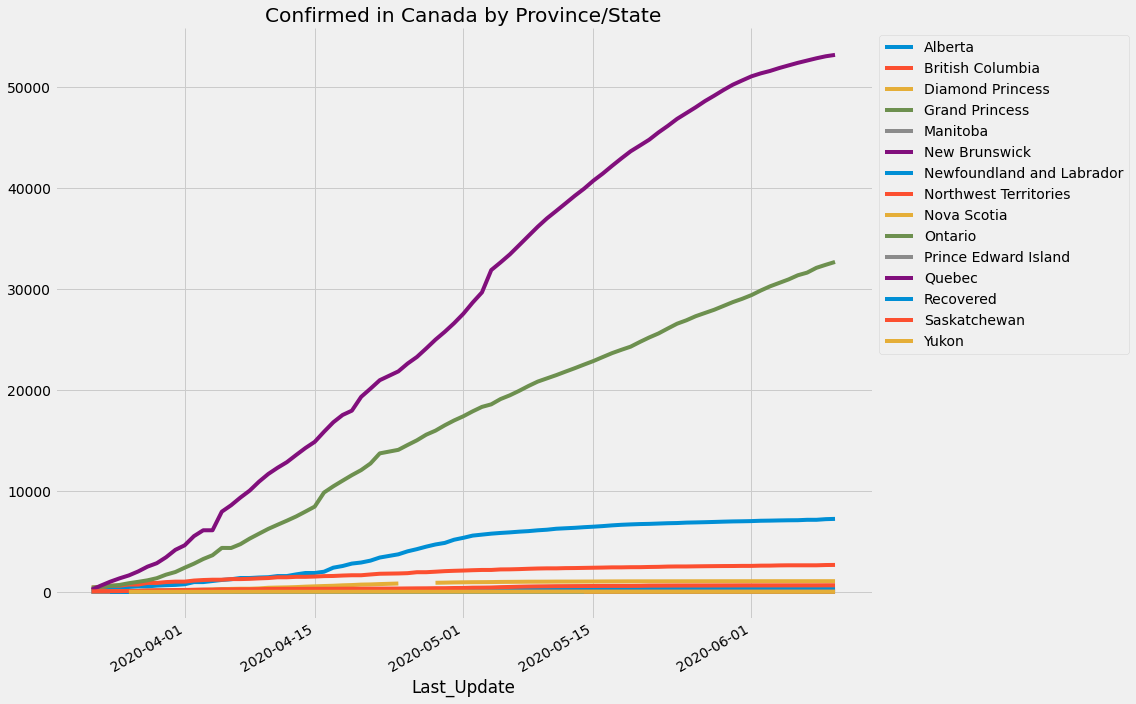

In [6]:
metric = 'Confirmed'
location = 'Canada'
(df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('{} in {} by Province/State'.format(metric, location))
plt.tight_layout()
sns.despine()
plt.show()

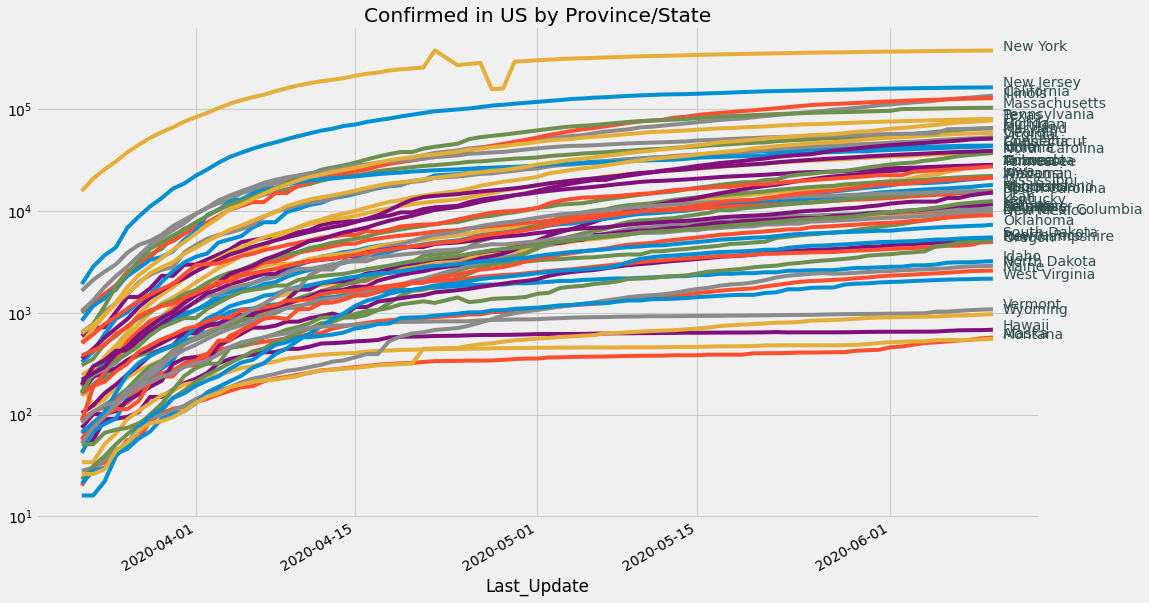

In [7]:
metric = 'Confirmed'
location = 'US'
graphdf = (df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03-22':,:]
     .drop(date.fromisoformat('2020-04-23'), axis=0) # this row has all NaNs which mess things up
     .dropna(axis=1, how='any')
     .drop(['Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Guam'], axis=1)
)
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=False)
plt.title('{} in {} by Province/State'.format(metric, location))
#plt.tight_layout()
sns.despine()
plt.show()


## Alternative one -- just use Combined_Key

In [8]:
#piv1 = df_clean.pivot_table(index=df_clean.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
#piv1.tail() # Note the MultiIndex for the columns (Metric, Combined_Key)

In [9]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'

#idx = pd.IndexSlice
#piv1.loc[:,idx['Deaths']]

In [10]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)

#piv1.loc[:,idx['Deaths', piv1.columns.map(lambda x: x[1].endswith('California, US'))]]

## Alternative Two (PREFERRED) - Use Country, State, Admin2 fields

First, an example of dealing with a column you want to use in a pivot_table that has nulls.

In [11]:
test = pd.DataFrame(
                    [
                        ['US','California',1],
                        ['US','New York',3],
                        ['Italy',np.NaN,10]
                    ],
                    columns = ['country', 'state', 'value'],
                   )
print(test)
print('\nIf you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)')
print(test.pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) )
print('\nNow do a .fillna(value={"column_name":"new_value"}) first and it is OK')
(test
     .fillna(value={'state':'none'})
     .pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) 
)

  country       state  value
0      US  California      1
1      US    New York      3
2   Italy         NaN     10

If you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)
             value         
country         US         
state   California New York
0              1.0      NaN
1              NaN      3.0

Now do a .fillna(value={"column_name":"new_value"}) first and it is OK


value                    
country Italy         US         
state    none California New York
0         NaN        1.0      NaN
1         NaN        NaN      3.0
2        10.0        NaN      NaN

## Create the final df  (note: long compute time here)

In [12]:
df = (df_clean
          .fillna(value={'Province_State':'none', 'Admin2':'none', 'Country_Region':'none'}) # if you don't do this, countries without state or admin2 will be filtered out.
          .pivot_table(index=df_clean.index, 
                          columns=['Metric','Country_Region','Province_State','Admin2'], 
                          values=['Value'], 
                          aggfunc=np.sum
                      )
     )
df = df.loc['20200322':,:]
df = df.drop(date.fromisoformat('2020-04-23'), axis=0) # this row has all NaNs which mess things up
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
...                    ...     ...     ...     ...    ...                 ...   
2020-06-06         16898.0   269.0  2792.0    60.0   61.0                 3.0   
2020-06-07         17394.0   273.0  2721.0    60.0   60.0                 3.0   
2020-06-08         18110.0   274.0  2730.0    57.0   63.0                 3.0   
2020-06-09         18377.0   284.0  2751.0    50.0   50.0                 3.0   
2020-06-10         18424.0   305.0  2707.0    44.0   54.0                 3.0   

                                                               \
Metric                                                          
Country_Region Argentina Armenia                    Australia   
Province_State      none    none Australian Capital Territory   
Admin2              none    none                         none   
Last_Update                                                     
2020-03-22         235.0   192.0                         19.0   
2020-03-23         235.0   233.0                         32.0   
2020-03-24         329.0   235.0                         39.0   
2020-03-25         327.0   249.0                         39.0   
2020-03-26         430.0   271.0                         52.0   
...                  ...     ...                          ...   
2020-06-06       14317.0  8121.0                          0.0   
2020-06-07       15192.0  8454.0                          1.0   
2020-06-08       15221.0  8916.0                          1.0   
2020-06-09       15622.0  9015.0                          1.0   
2020-06-10       16476.0  9007.0                          1.0   

                                     ...                                    \
Metric                               ...      Recovered                      
Country_Region                       ... United Kingdom Uruguay Uzbekistan   
Province_State External territories  ...           none    none       none   
Admin2                         none  ...           none    none       none   
Last_Update                          ...                                     
2020-03-22                      0.0  ...           93.0     0.0        0.0   
2020-03-23                      NaN  ...          135.0     0.0        0.0   
2020-03-24                      NaN  ...          135.0     0.0        0.0   
2020-03-25                      NaN  ...          135.0     0.0        0.0   
2020-03-26                      NaN  ...          135.0     0.0        0.0   
...                             ...  ...            ...     ...        ...   
2020-06-06                      NaN  ...            0.0   721.0     3247.0   
2020-06-07                      NaN  ...            0.0   726.0     3268.0   
2020-06-08                      NaN  ...            0.0   730.0     3354.0   
2020-06-09                      NaN  ...            0.0   738.0     3357.0   
2020-06-10                      NaN  ...            0.0   754.0     3459.0   

                                                                          \
Metric                                                                     
Country_Region Venezuela Vietnam West Bank and Gaza Wester

### Trick: Using pd.IndexSlice and slice()

In [13]:
idx = pd.IndexSlice
Any = slice(None)  # could also just use ":", but this is a bit clearer

df.loc[:,idx[Any,Any,Any,Any,'Santa Clara']]

Value                                              \
Metric              Active Case-Fatality_Ratio   Confirmed      Deaths   
Country_Region          US                  US          US          US   
Province_State  California          California  California  California   
Admin2         Santa Clara         Santa Clara Santa Clara Santa Clara   
Last_Update                                                              
2020-03-22             0.0            0.000000       263.0         8.0   
2020-03-23             0.0            0.000000       302.0        10.0   
2020-03-24             0.0            0.000000       375.0        16.0   
2020-03-25             0.0            0.000000       459.0        17.0   
2020-03-26             0.0            0.000000       542.0        19.0   
...                    ...                 ...         ...         ...   
2020-06-06          2748.0            4.979253      2892.0       144.0   
2020-06-07          2777.0            4.897260      2920.0       143.0   
2020-06-08          2798.0            4.894630      2942.0       144.0   
2020-06-09          2828.0            4.877228      2973.0       145.0   
2020-06-10          2871.0            4.839244      3017.0       146.0   

                                           
Metric         Incidence_Rate   Recovered  
Country_Region             US          US  
Province_State     California  California  
Admin2            Santa Clara Santa Clara  
Last_Update                                
2020-03-22           0.000000         0.0  
2020-03-23           0.000000         0.0  
2020-03-24           0.000000         0.0  
2020-03-25           0.000000         0.0  
2020-03-26           0.000000         0.0  
...                       ...         ...  
2020-06-06         150.011515         0.0  
2020-06-07         151.463909         0.0  
2020-06-08         152.605075         0.0  
2020-06-09         154.213083         0.0  
2020-06-10         156.495416         0.0  

[80 rows x 6 columns]

### Trick:  Deleting columns with all zeros

In [14]:
test = pd.DataFrame([[1,0,0,0], [0,0,0,0],[0,0,1,0]], columns=['a','b','c','d'])
print(test)

print('\n"test!=0"  gives a true/false where there are non-zeros')
print(test!=0)

print('\nThe "any" function with axis=0 reduces along row to give true for any column with a true in it')
print((test!=0).any(axis=0))

print('\nNow just select the rows with a true in order to drop the columns with all zeros\ntest.loc[:,(test!=0).any(axis=0)]')
print(test.loc[:,(test!=0).any(axis=0)])

print('\nTo drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead \ntest.loc[(test!=0).any(axis=1),:]')
print(test.loc[(test!=0).any(axis=1),:])

   a  b  c  d
0  1  0  0  0
1  0  0  0  0
2  0  0  1  0

"test!=0"  gives a true/false where there are non-zeros
       a      b      c      d
0   True  False  False  False
1  False  False  False  False
2  False  False   True  False

The "any" function with axis=0 reduces along row to give true for any column with a true in it
a     True
b    False
c     True
d    False
dtype: bool

Now just select the rows with a true in order to drop the columns with all zeros
test.loc[:,(test!=0).any(axis=0)]
   a  c
0  1  0
1  0  0
2  0  1

To drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead 
test.loc[(test!=0).any(axis=1),:]
   a  b  c  d
0  1  0  0  0
2  0  0  1  0


In [15]:
# eliminate all the columns that are all zero and all the rows that are all zero
# note how using lambda allows us to do this without using temp variables for the 'deaths'/'california' subset
test = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
test

Value                                                   \
Metric             Deaths                                                    
Country_Region         US                                                    
Province_State California                                                    
Admin2            Alameda Butte Contra Costa Fresno Humboldt Imperial Inyo   
Last_Update                                                                  
2020-03-22            0.0   0.0          1.0    0.0      0.0      0.0  0.0   
2020-03-23            1.0   0.0          1.0    0.0      0.0      0.0  0.0   
2020-03-24            2.0   0.0          1.0    0.0      0.0      0.0  0.0   
2020-03-25            2.0   0.0          1.0    0.0      0.0      0.0  0.0   
2020-03-26            4.0   0.0          1.0    0.0      0.0      0.0  0.0   
...                   ...   ...          ...    ...      ...      ...  ...   
2020-06-06          101.0   1.0         38.0   40.0      4.0     33.0  1.0   
2020-06-07          101.0   1.0         38.0   43.0      4.0     33.0  1.0   
2020-06-08          101.0   1.0         39.0   43.0      4.0     33.0  1.0   
2020-06-09          101.0   1.0         40.0   43.0      4.0     38.0  1.0   
2020-06-10          102.0   1.0         43.0   46.0      4.0     38.0  1.0   

                                        ...                                  \
Metric                                  ...                                   
Country_Region                          ...                                   
Province_State                          ...                                   
Admin2          Kern Kings Los Angeles  ... Solano Sonoma Stanislaus Sutter   
Last_Update                             ...                                   
2020-03-22       0.0   0.0         5.0  ...    0.0    1.0        0.0    0.0   
2020-03-23       0.0   0.0         7.0  ...    0.0    1.0        0.0    0.0   
2020-03-24       0.0   0.0        11.0  ...    0.0    1.0        0.0    0.0   
2020-03-25       0.0   0.0        13.0  ...    0.0    1.0        0.0    0.0   
2020-03-26       0.0   0.0        21.0  ...    0.0    1.0        0.0    0.0   
...              ...   ...         ...  ...    ...    ...        ...    ...   
2020-06-06      45.0   6.0      2569.0  ...   22.0    4.0       31.0    2.0   
2020-06-07      45.0   6.0      2624.0  ...   23.0    4.0       31.0    2.0   
2020-06-08      45.0   6.0      2645.0  ...   23.0    4.0       33.0    2.0   
2020-06-09      47.0   6.0      2656.0  ...   23.0    4.0       33.0    2.0   
2020-06-10      47.0   6.0      2710.0  ...   23.0    4.0       33.0    2.0   

                                                            
Metric                                                      
Country_Region                                              
Province_State                                              
Admin2         Tehama Tulare Unassigned Ventura  Yolo Yuba  
Last_Update                                                 
2020-03-22        0.0    0.0        0.0     0.0   0.0  0.0  
2020-03-23        0.0    0.0        0.0     1.0   1.0  0.0  
2020-03-24        0.0    0.0        0.0     1.0   1.0  0.0  
2020-03-25        0.0    0.0        0.0     1.0   1.0  0.0  
2020-03-26        0.0    0.0        0.0     1.0   1.0  0.0  
...               ...    ...        ...     ...   ...  ...  
2020-06-06        1.0   92.0        0.0    35.0  24.0  1.0  
2020-06-07        1.0   92.0        0.0    35.0  24.0  1.0  
2020-06-08        1.0   92.0        0.0    35.0  24.0  1.0  
2020-06-09        1.0   94.0        0.0    35.0  24.0  1.0  
2020-06-10        1.0   94.0        0.0    35.0  24.0  1.0  

[80 rows x 44 columns]

### Eliminate all columns and rows that are all zero in df

In [16]:

# eliminate all the columns that are all zero and all the rows that are all zero
df = (df
           .fillna(value=0)                        # replace NaN with zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
...                    ...     ...     ...     ...    ...                 ...   
2020-06-06         16898.0   269.0  2792.0    60.0   61.0                 3.0   
2020-06-07         17394.0   273.0  2721.0    60.0   60.0                 3.0   
2020-06-08         18110.0   274.0  2730.0    57.0   63.0                 3.0   
2020-06-09         18377.0   284.0  2751.0    50.0   50.0                 3.0   
2020-06-10         18424.0   305.0  2707.0    44.0   54.0                 3.0   

                                                                               \
Metric                                                                          
Country_Region Argentina Armenia                    Australia                   
Province_State      none    none Australian Capital Territory New South Wales   
Admin2              none    none                         none            none   
Last_Update                                                                     
2020-03-22         235.0   192.0                         19.0           659.0   
2020-03-23         235.0   233.0                         32.0           659.0   
2020-03-24         329.0   235.0                         39.0           807.0   
2020-03-25         327.0   249.0                         39.0          1018.0   
2020-03-26         430.0   271.0                         52.0          1208.0   
...                  ...     ...                          ...             ...   
2020-06-06       14317.0  8121.0                          0.0           343.0   
2020-06-07       15192.0  8454.0                          1.0           338.0   
2020-06-08       15221.0  8916.0                          1.0           340.0   
2020-06-09       15622.0  9015.0                          1.0           337.0   
2020-06-10       16476.0  9007.0                          1.0           334.0   

                ...                                                      \
Metric          ...      Recovered                                        
Country_Region  ... United Kingdom Uruguay Uzbekistan Venezuela Vietnam   
Province_State  ...           none    none       none      none    none   
Admin2          ...           none    none       none      none    none   
Last_Update     ...                                                       
2020-03-22      ...           93.0     0.0        0.0      15.0    17.0   
2020-03-23      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-24      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-25      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-26      ...          135.0     0.0        0.0      15.0    20.0   
...             ...            ...     ...        ...       ...     ...   
2020-06-06      ...            0.0   721.0     3247.0     334.0   307.0   
2020-06-07      ...            0.0   726.0     3268.0     385.0   307.0   
2020-06-08      ...            0.0   730.0     3354.0     487.0   307.0   
2020-06-09      ...            0.0   738.0     3357.0     487.0   316.0   
2020-06-10      ...            0.0   754.0     3459.0     487.0  

### Graph examples with df

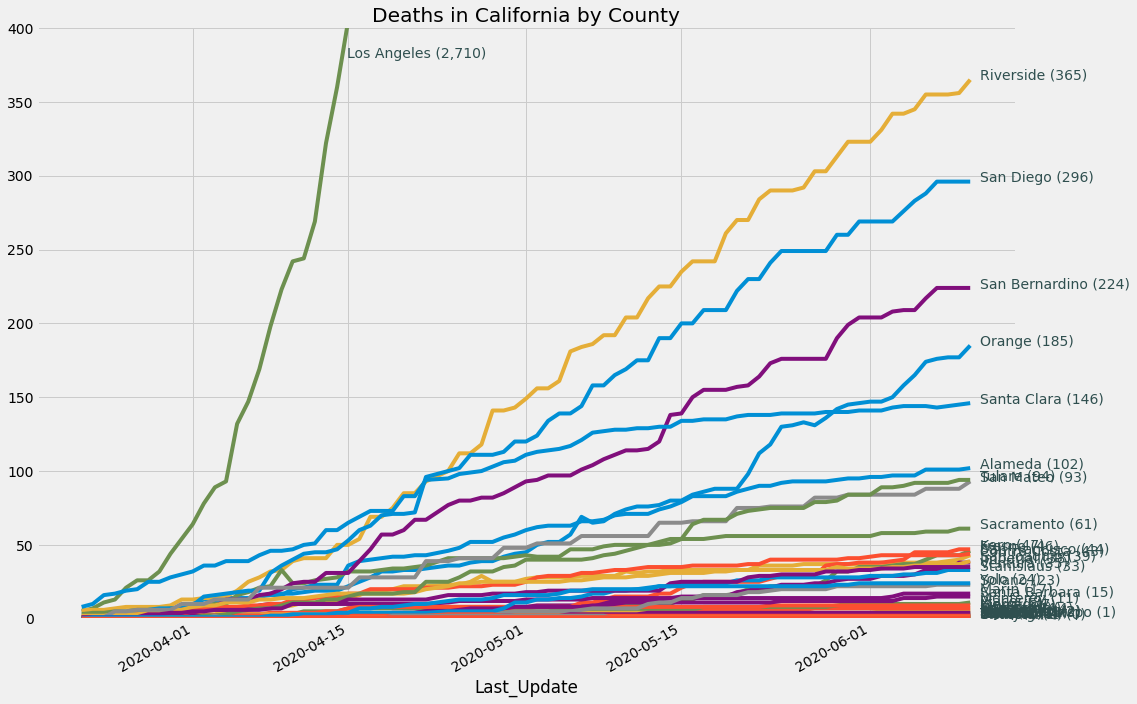

In [17]:
# graph example        
graphdf = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
ax = graphdf.plot(legend=False, ylim=(0,400))
label_lines(graphdf, ax, tuple_selector=4, print_value=True)
plt.title('Deaths in California by County')
plt.tight_layout()
sns.despine()
plt.show()

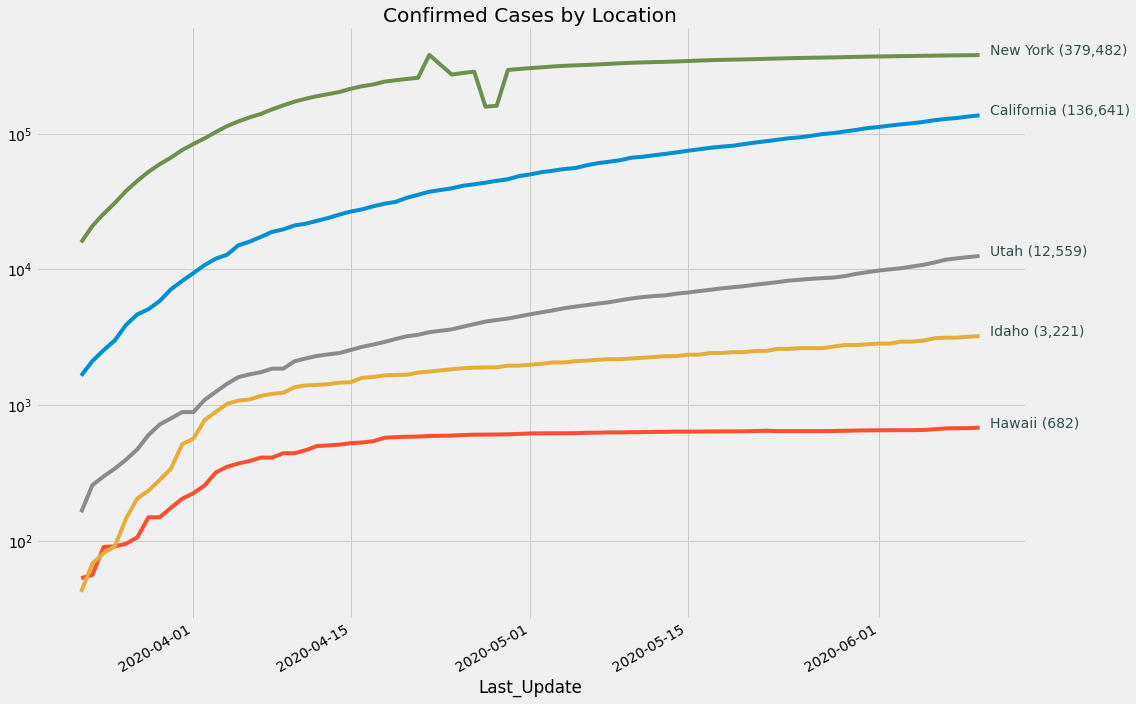

In [18]:
graphdf = (df.loc[:,idx[Any,'Confirmed',Any,['California', 'Utah', 'New York', 'Hawaii', 'Idaho'],Any]]
           .groupby('Province_State', axis='columns')
           .sum()
          )
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=True)
plt.title('Confirmed Cases by Location')
plt.tight_layout()
sns.despine()
plt.show()


## Creating a table with just a selection of locations (pulled from different levels - countries, states, counties)

In [19]:
# recall that at this point, df has a MultiIndex column structure with the following levels:
#         Metric
#         Country_Region
#         Province_State
#         Admin2
# and it has 'Last_Update' as the index.
# so an indexer refers to the following elements:
#    idx [:,             :,      :,         :,      :]
#         last_update    metric  country    region  admin2

locations = {
    'Province_State': idx[:,:,:,['California', 'Utah', 'New York', 'Hawaii', 'Idaho', 'Texas', 'Georgia', 'Illinois'],:],
    'Country_Region': idx[:,:,['Italy', 'US', 'Spain', 'Japan', 'Singapore'],:,:],
    'Admin2':         idx[:,:,:,:,['Santa Clara', 'Los Angeles']]
}
last_table = None

for level, indexer in locations.items():
    temp = (df.loc[:,indexer]
           .groupby(['Metric',level], axis='columns')
           .sum()
       )
    # change 'Province_State' or 'Country_Region', etc. to 'Location'
    temp.rename_axis(('Metric', 'Location'), axis="columns", inplace=True)
    #print(temp.head(1))
    #print(temp.info())
    if last_table is None:
        last_table = temp
        continue          # skip the concat on the first run
    last_table = pd.concat([last_table, temp], axis=1)
df_select = last_table
df_select

Metric          Active                                                       \
Location    California  Georgia Hawaii   Idaho  Illinois  New York    Texas   
Last_Update                                                                   
2020-03-22         0.0      0.0    0.0     0.0       0.0       0.0      0.0   
2020-03-23         0.0      0.0    0.0     0.0       0.0       0.0      0.0   
2020-03-24         0.0      0.0    0.0     0.0       0.0       0.0      0.0   
2020-03-25         0.0      0.0    0.0     0.0       0.0       0.0      0.0   
2020-03-26         0.0      0.0    0.0     0.0       0.0       0.0      0.0   
...                ...      ...    ...     ...       ...       ...      ...   
2020-06-06    121209.0  48447.0  647.0  3028.0  120120.0  345972.0  70736.0   
2020-06-07    123987.0  49181.0  656.0  3056.0  121026.0  347036.0  72637.0   
2020-06-08    125983.0  49718.0  658.0  3056.0  121853.0  347723.0  73567.0   
2020-06-09    129159.0  50289.0  659.0  3106.0  122491.0  348382.0  74615.0   
2020-06-10    131896.0  50964.0  665.0  3136.0  123194.0  349024.0  76263.0   

Metric               Case-Fatality_Ratio              ...      Active  \
Location        Utah          California     Georgia  ... Los Angeles   
Last_Update                                           ...               
2020-03-22       0.0            0.000000    0.000000  ...         0.0   
2020-03-23       0.0            0.000000    0.000000  ...         0.0   
2020-03-24       0.0            0.000000    0.000000  ...         0.0   
2020-03-25       0.0            0.000000    0.000000  ...         0.0   
2020-03-26       0.0            0.000000    0.000000  ...         0.0   
...              ...                 ...         ...  ...         ...   
2020-06-06   11132.0          144.139181  674.466593  ...     58499.0   
2020-06-07   11677.0          139.790075  670.997145  ...     59758.0   
2020-06-08   11945.0          139.049525  673.371149  ...     61199.0   
2020-06-09   12198.0          133.870128  672.176607  ...     62034.0   
2020-06-10   12432.0          130.963246  673.156790  ...     63235.0   

Metric                  Case-Fatality_Ratio               Confirmed  \
Location    Santa Clara         Los Angeles Santa Clara Los Angeles   
Last_Update                                                           
2020-03-22          0.0            0.000000    0.000000       407.0   
2020-03-23          0.0            0.000000    0.000000       536.0   
2020-03-24          0.0            0.000000    0.000000       662.0   
2020-03-25          0.0            0.000000    0.000000       812.0   
2020-03-26          0.0            0.000000    0.000000      1229.0   
...                 ...                 ...         ...         ...   
2020-06-06       2748.0            4.206786    4.979253     61068.0   
2020-06-07       2777.0            4.206342    4.897260     62382.0   
2020-06-08       2798.0            4.142911    4.894630     63844.0   
2020-06-09       2828.0            4.105735    4.877228     64690.0   
2020-06-10       2871.0            4.109485    4.839244     65945.0   

Metric                       Deaths             Incidence_Rate              
Location    Santa Clara Los Angeles Santa Clara    Los Angeles Santa Clara  
Last_Update                                                                 
2020-03-22        263.0         5.0         8.0       0.000000    0.000000  
2020-03-23        302.0         7.0        10.0       0.000000    0.000000  
2020-03-24        375.0        11.0        16.0       0.000000    0.000000  
2020-03-25        459.0        13.0        17.0       0.000000    0.000000  
2020-03-26        542.0        21.0        19.0       0.000000    0.000000  
...                 ...         ...         ...            ...         ...  
2020-06-06       2892.0      2569.0       144.0     608.301117  150.011515  
2020-06-07       2920.0      2624.0       143.0     621.389930  151.463909  
2020-06-08       2942.0     

## Create a single-metric *table* from df_select

In [20]:
# To get the values as they are in df_select (i.e cumulative values), 
#it is easy -- just select the metric column. Since Metric is the 
#first level of the MultiIndex column you can just index it like this:

df_select['Deaths'].head(2)

Location,California,Georgia,Hawaii,Idaho,Illinois,New York,Texas,Utah,Italy,Japan,Singapore,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,,,,,,
2020-03-22,30.0,25.0,0.0,0.0,9.0,117.0,7.0,1.0,5476.0,36.0,2.0,1756.0,427.0,5.0,8.0
2020-03-23,39.0,25.0,0.0,0.0,12.0,158.0,9.0,1.0,6077.0,42.0,2.0,2311.0,552.0,7.0,10.0


In [21]:
# Or, to retain the multiIndex, you could use multiindex indexing:
df_select.loc[:,idx['Deaths',:]].head(2)

Metric          Deaths                                                    \
Location    California Georgia Hawaii Idaho Illinois New York Texas Utah   
Last_Update                                                                
2020-03-22        30.0    25.0    0.0   0.0      9.0    117.0   7.0  1.0   
2020-03-23        39.0    25.0    0.0   0.0     12.0    158.0   9.0  1.0   

Metric                                                                      
Location      Italy Japan Singapore   Spain     US Los Angeles Santa Clara  
Last_Update                                                                 
2020-03-22   5476.0  36.0       2.0  1756.0  427.0         5.0         8.0  
2020-03-23   6077.0  42.0       2.0  2311.0  552.0         7.0        10.0

In [22]:
# ...and then drop the unneeded multindex level
(df_select.loc[:,idx['Deaths',:]]
     .droplevel(level=0, axis=1)
).head(2)


Location,California,Georgia,Hawaii,Idaho,Illinois,New York,Texas,Utah,Italy,Japan,Singapore,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,,,,,,
2020-03-22,30.0,25.0,0.0,0.0,9.0,117.0,7.0,1.0,5476.0,36.0,2.0,1756.0,427.0,5.0,8.0
2020-03-23,39.0,25.0,0.0,0.0,12.0,158.0,9.0,1.0,6077.0,42.0,2.0,2311.0,552.0,7.0,10.0


In [23]:
# ...This last method works if you want to select the *second* level
(df_select.loc[:,idx[:,'California']]
     .droplevel(level=1, axis=1)
).head(2)


Metric,Active,Case-Fatality_Ratio,Confirmed,Deaths,Incidence_Rate
Last_Update,,,,,
2020-03-22,0.0,0.0,1646.0,30.0,0.0
2020-03-23,0.0,0.0,2108.0,39.0,0.0


## Create a single-metric *database* from df_select
### this is a melted list of points suitable for use with sns, etc.

In [24]:
graphdf = df_select['Deaths'].reset_index().melt(id_vars=['Last_Update'])
graphdf

,Last_Update,Location,value
0,2020-03-22,California,30.0
1,2020-03-23,California,39.0
2,2020-03-24,California,50.0
3,2020-03-25,California,65.0
4,2020-03-26,California,81.0
...,...,...,...
1195,2020-06-06,Santa Clara,144.0
1196,2020-06-07,Santa Clara,143.0
1197,2020-06-08,Santa Clara,144.0
1198,2020-06-09,Santa Clara,145.0


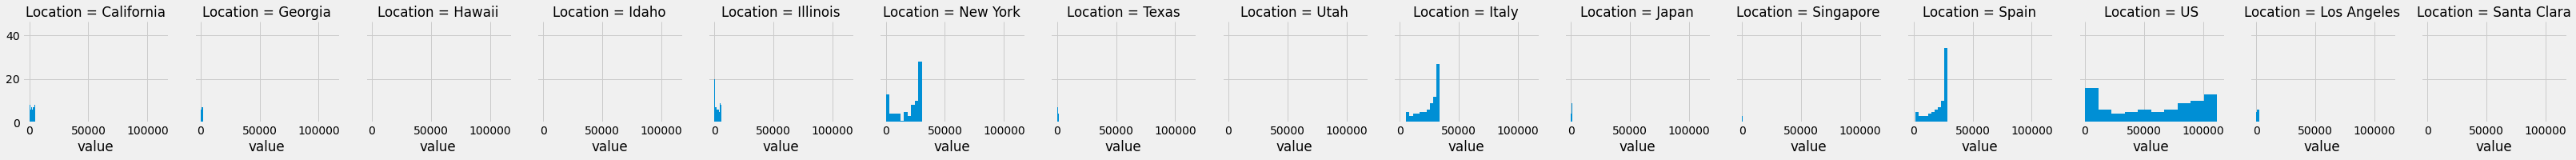

In [25]:
g = sns.FacetGrid(graphdf, col='Location')
g.map(plt.hist, 'value');

## Create a single-metric *table* from df_select and CONVERTING to daily instead of cumulative

## Creating a delta table from this cumulative data

In [26]:
# df is cumulative for most of the metrics
# sometimes we want just the daily deltas, not the cumulative numbers
# We can use DataFrame.diff() for this, but must do it within an individual Metric/Location
daily_deaths_df = (df_select.loc[:,idx['Deaths',:]]
                     .droplevel(level=0, axis=1)
                     .diff(periods=1)  # periods=1 would be daily (one row minus row before)
                     .iloc[1:,:] #drop the first row since it will be NaN
)
daily_deaths_df

Location,California,Georgia,Hawaii,Idaho,Illinois,New York,Texas,Utah,Italy,Japan,Singapore,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,,,,,,
2020-03-23,9.0,0.0,0.0,0.0,3.0,41.0,2.0,0.0,601.0,6.0,0.0,555.0,125.0,2.0,2.0
2020-03-24,11.0,7.0,1.0,0.0,4.0,52.0,3.0,0.0,743.0,1.0,0.0,497.0,154.0,4.0,6.0
2020-03-25,15.0,8.0,-1.0,0.0,3.0,75.0,3.0,0.0,683.0,2.0,0.0,839.0,236.0,2.0,1.0
2020-03-26,16.0,8.0,0.0,3.0,7.0,100.0,6.0,0.0,712.0,2.0,0.0,718.0,267.0,8.0,2.0
2020-03-27,13.0,16.0,0.0,0.0,8.0,142.0,5.0,0.0,919.0,2.0,0.0,773.0,372.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-06,85.0,25.0,0.0,0.0,59.0,62.0,36.0,3.0,85.0,5.0,0.0,1.0,1162.0,37.0,0.0
2020-06-07,77.0,4.0,0.0,0.0,69.0,44.0,21.0,1.0,72.0,-1.0,1.0,1.0,710.0,55.0,-1.0
2020-06-08,26.0,2.0,0.0,0.0,40.0,94.0,8.0,0.0,53.0,2.0,0.0,1.0,445.0,21.0,1.0


### Solving for missing values in the cumulative data

In [27]:
# Note that the method above will have errors if there are any missing values
# in the original cumulative data (which will have been filled with zeros).
# To solve for this, replace any zeros in the data with the previous value (using .replace())
#
# I'm also restricting to april 1st or later because some locations have funky data in the first few
# days after 3/22
daily_deaths_df = (df_select.loc['20200401':,idx['Deaths',:]]
                     .droplevel(level=0, axis=1)
                     .apply(lambda x: x.replace(to_replace=0, method='ffill'), axis=1) # replace zeros with prev value                   
                     .diff(periods=1)  # periods=1 would be daily (one row minus row before)
                     .iloc[1:,:] #drop the first row since it will be NaN
)
daily_deaths_df
#print(daily_deaths_df['Idaho'].values)

Location,California,Georgia,Hawaii,Idaho,Illinois,New York,Texas,Utah,Italy,Japan,Singapore,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,,,,,,
2020-04-02,39.0,24.0,0.0,0.0,22.0,432.0,11.0,2.0,760.0,5.0,1.0,961.0,1169.0,14.0,4.0
2020-04-03,27.0,21.0,2.0,0.0,47.0,562.0,23.0,0.0,766.0,1.0,1.0,850.0,1161.0,11.0,0.0
2020-04-04,24.0,17.0,0.0,1.0,34.0,630.0,16.0,1.0,681.0,14.0,1.0,749.0,1320.0,4.0,3.0
2020-04-05,59.0,10.0,1.0,0.0,30.0,594.0,20.0,0.0,525.0,0.0,0.0,694.0,1212.0,39.0,0.0
2020-04-06,32.0,18.0,1.0,0.0,33.0,539.0,14.0,5.0,636.0,8.0,0.0,700.0,1164.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-06,85.0,25.0,0.0,0.0,59.0,62.0,36.0,3.0,85.0,5.0,0.0,1.0,1162.0,37.0,0.0
2020-06-07,77.0,4.0,0.0,0.0,69.0,44.0,21.0,1.0,72.0,-1.0,1.0,1.0,710.0,55.0,-1.0
2020-06-08,26.0,2.0,0.0,0.0,40.0,94.0,8.0,0.0,53.0,2.0,0.0,1.0,445.0,21.0,1.0


## Custom Graph Grid

In [28]:
def my_deathplot(ax, datax, datay, param_dict={}):
    """
    A helper function to make a graph
    param_dict : dict       Dictionary of kwargs to pass to ax.plot
    Returns
    -------
    out : list        list of artists added
    """
    out = ax.bar(datax, datay, **param_dict)
    return out

3 5
['California' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'New York' 'Texas'
 'Utah' 'Italy' 'Japan' 'Singapore' 'Spain' 'US' 'Los Angeles'
 'Santa Clara']


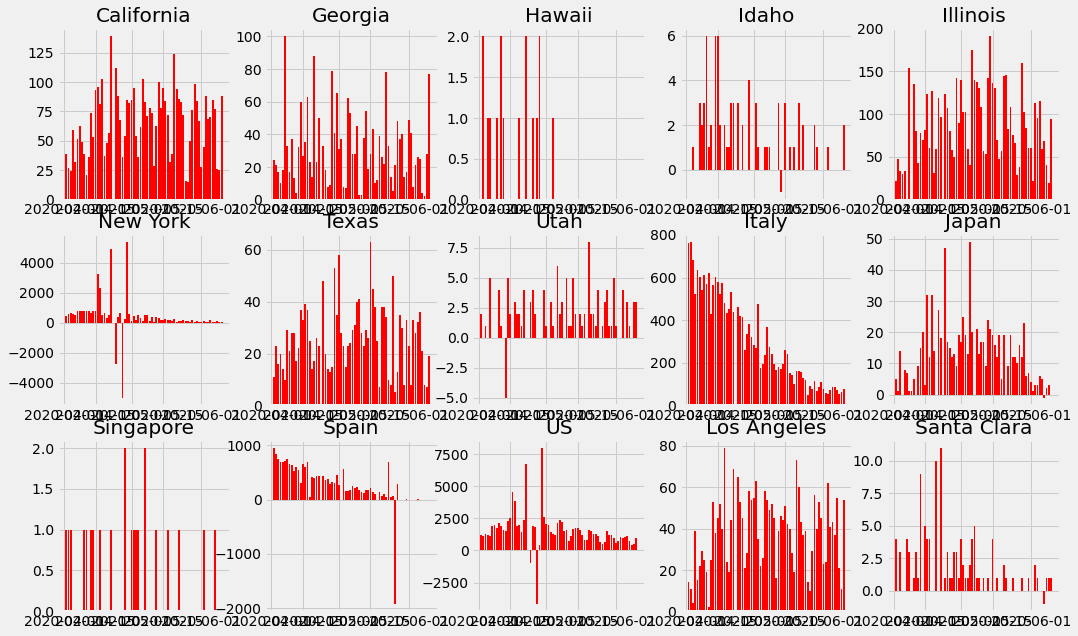

In [29]:
graphdf = daily_deaths_df

fig, axes_array = plt.subplots(3,5)
print(len(axes_array),len(axes_array[0]))
locations = graphdf.columns.values
print(locations)
count = 0
params = {'linewidth':0, 'color':'red'}
for axes_row in range(len(axes_array)):
    for axes_col in range(len(axes_array[0])):
        if(count >= len(locations)):
            break
        location = locations[count]
        count += 1
        data = graphdf.loc[:,location]
        axes_array[axes_row][axes_col].set_title(location)
        my_deathplot(axes_array[axes_row][axes_col], data.index.values, data.values, params)
fig.savefig('deaths_grid.png')

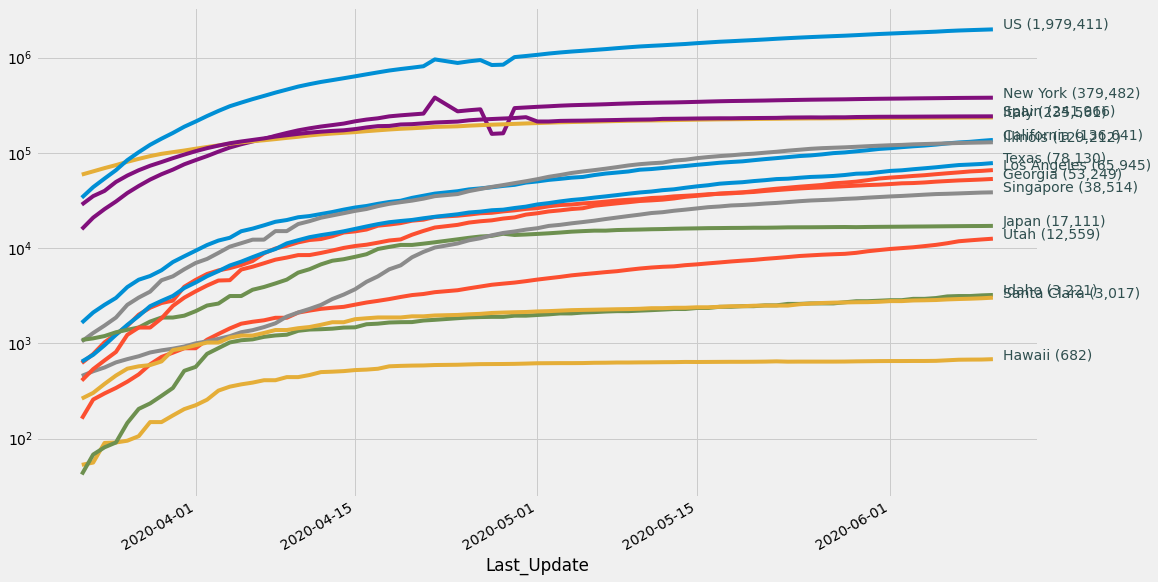

In [30]:
graphdf = df_select['Confirmed']
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, print_value=True)